# The Toy Shape Dataset

 - A toy shapes dataset: small resolution image composed of squares, circles an triangles.
 - Strongly inspired from [this implementation](https://github.com/matterport/Mask_RCNN/blob/cbff80f3e3f653a9eeee43d0d383a0385aba546b/samples/shapes/shapes.py).
 - The [config.yaml file](./config.yaml) should be able to train the dataset composed of 50 images in less than 10 minutes on a regular GPU with a **mAP@[0.5:0.95] of ~70%**.
 
This dataset is ideal for debugging and educational purpose..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tqdm

import sys; sys.path.append("../../../")
import maskflow

import utils

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

# Load the configuration.
config = maskflow.load_config("config.yaml")

# Copy config next to data folder.
maskflow.save_config(config, root_dir / "config.yaml")

## Generate the dataset

In [2]:
height = config["DATASET"]["IMAGE_SIZE"]
width = config["DATASET"]["IMAGE_SIZE"]
class_names = config["DATASET"]["CLASS_NAMES"]

count = 50
max_n_per_image = 4
training_size = 0.9  # From 0 to 1
encoded_mask_format = "png"

train_ids, _ = train_test_split(np.arange(0, count), train_size=training_size)

train_features_example = []
test_features_example = []

train_file_path = data_dir / "train.tfrecords"
test_file_path = data_dir / "test.tfrecords"

for image_id in tqdm.trange(count):
    # Generate image specification
    bg_color, shapes = utils.random_image(height, width, max_n_per_image, class_names)
    
    # Generate the image
    image = utils.generate_image(bg_color, height, width, shapes)
    
    # Generate the masks
    masks, label_ids = utils.generate_mask(bg_color, height, width, shapes, class_names)
    
    filename = f"toy_{image_id:04d}.png"
    features_dict = maskflow.dataset.build_features_dict(image, image_id, filename, masks,
                                                         label_ids, class_names,
                                                         encoded_mask_format=encoded_mask_format,
                                                         save_objects=True)
    
    example = tf.train.Example(features=tf.train.Features(feature=features_dict))
    
    if image_id in train_ids:
        train_features_example.append(example)
    else:
        test_features_example.append(example)
        
# Write examples to TFRecord files.
with tf.io.TFRecordWriter(str(train_file_path)) as writer:
    for example in train_features_example:
        writer.write(example.SerializeToString())
        
with tf.io.TFRecordWriter(str(test_file_path)) as writer:
    for example in test_features_example:
        writer.write(example.SerializeToString())

100%|██████████| 50/50 [00:00<00:00, 170.45it/s]


## Visualize some images with their masks

### TODO

- convert to bboxes
- pad datum to be able to batch
- make plot

In [19]:
train_dataset = maskflow.dataset.parse(train_file_path, parse_objects=True)
for datum in train_dataset.take(10):
    pass

In [20]:
datum['image/object/bbox/x'].shape

TensorShape([1])

In [21]:
datum['masks'].shape

TensorShape([1, 128, 128])

In [17]:
import importlib.resources as resources

2018-11-10 18:49:43,757:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


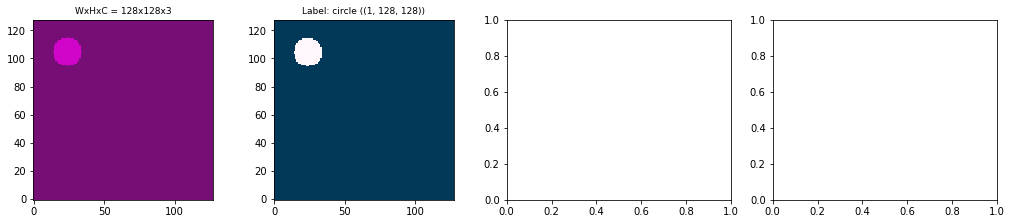

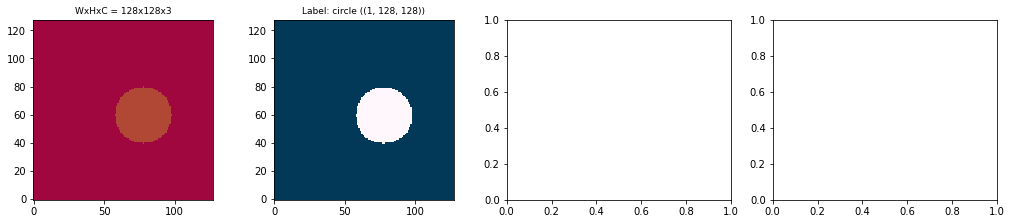

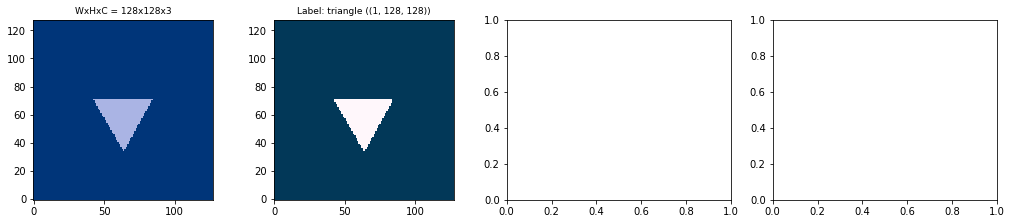

In [3]:
# Number of batch to load
n = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(train_dataset, basesize=14, limit=3, cmap="PuBu_r")